## Part 2 - Analyse the Land Use Changes
#### Notebook outline:

This notebook outlines the initial analysis of vegetation classes and changes to other land uses. 

These functions requires the following libraries:

In [3]:
import rasterio
import xarray as xr

import rioxarray as rio
from rasterio.plot import show
from rasterio.windows import from_bounds

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from  matplotlib.cm import ScalarMappable
from  matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FormatStrFormatter


import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline

##### Function:
This function calculates the percentage composition for each vegetation class within the defined site and specified time period.

In [12]:
def vegetation_area_analysis_perc(start_year,end_year,sample_site,site_x_origin,site_y_origin,site_size):

    
    """
    
    This function creates an output csv of percentage composition for each vegetation class for the sample site defined. 
    
    start_year = first year to calculate areas for
    end_year = final year to calculate areas for
    sample_site = site name for title label and file name (Follow convention 'Control Site' or 'Sample Site #')
    site_x_origin = bottom left x-coordinate of sample site in geographic coordinates
    site_y_origin = bottom left y-coordinate of sample site in geographic coordinates
    site_size = size of sample site in geographic coordinates
    
    Datasources:
    
    1. The vegetation raster data is extracted from https://code.earthengine.google.com/?scriptPath=users%2Fmapbiomas%2Fuser-toolkit%3Amapbiomas-user-toolkit-lulc.js
    2. Legend codes for vegetation classes were taken from https://s3.amazonaws.com/amazonia.mapbiomas.org/leyenda/C%C3%B3digo_de_la_Leyenda_-_colecci%C3%B3n_4.pdf
    

    """
    
    year = start_year
    
    # Download the colour codes for vegetation classes - extract from a saved CSV file

    colorCode = pd.read_csv('Colour Codes for Vegetation.csv')
    colorCode.drop(columns=['ClassesBR'],inplace=True)
    colorCode
    
    # Extract original colours
    sortColor = colorCode.sort_values('ID')

    vals = sortColor['ID'].values
    cols = sortColor['HexCode'].values
    bounds = np.append(vals, vals[-1] + 1)

    cmap = ListedColormap(cols)
    norm = BoundaryNorm(bounds, ncolors=len(cols))

    
    while year <= end_year:

        #Loading in the dataset

        ds = rio.open_rasterio("https://storage.googleapis.com/mapbiomas-public/initiatives/brasil/collection_8/lclu/coverage/brasil_coverage_"+str(year)+".tif")


        # Slice to the sample site

        ds_clip = ds.sel(x=slice(site_x_origin,(site_x_origin + site_size)),y=slice((site_y_origin + site_size),site_y_origin)).isel(band=0)


        # Counting the area for the each vegetation class

        totalArea = (111*site_size)**2 # in km2 - assumes 1 degree of longititude and latitude is the same and near the equator it is about 111km
        totalPix = ds_clip.size # number on pixel for the clipped dataset

        count = []
        for k in range(len(colorCode)):
            classID = colorCode['ID'].values[k]
            count.append(ds_clip.where(ds_clip==classID).count().values+0)

        colorCode['count'] = count
        colorCode['perc'+str(year)] = np.round(((np.asarray(count)/totalPix)*100),3)
        vegAnalysis = colorCode.copy()
        vegAnalysis.drop(columns=['HexCode', 'count', 'ID'],inplace=True)
        vegAnalysis

        year += 1
        

    # Plot to csv
    vegAnalysis.to_csv('vegetation_analysis_sample_site_perc_'+str(sample_site)+'_'+str(start_year)+'-'+str(end_year)+'.csv',index=False)

    return

##### Function:
This function calculates the area in km2 each vegetation class within the defined site and specified time period.

In [13]:
def vegetation_area_analysis_area(start_year,end_year,sample_site,site_x_origin,site_y_origin,site_size):

    
    """
    
    This function creates an output csv of area calculations for each vegetation class for the sample site defined. 
    
    start_year = first year to calculate areas for
    end_year = final year to calculate areas for
    sample_site = sample site name for file naming
    site_x_origin = bottom left x-coordinate of sample site in geographic coordinates
    site_y_origin = bottom left y-coordinate of sample site in geographic coordinates
    site_size = size of sample site in geographic coordinates
    
    Datasources:
    
    1. The vegetation raster data is extracted from https://code.earthengine.google.com/?scriptPath=users%2Fmapbiomas%2Fuser-toolkit%3Amapbiomas-user-toolkit-lulc.js
    2. Legend codes for vegetation classes were taken from https://s3.amazonaws.com/amazonia.mapbiomas.org/leyenda/C%C3%B3digo_de_la_Leyenda_-_colecci%C3%B3n_4.pdf
    

    """
    
    year = start_year
    
    # Download the colour codes for vegetation classes - extract from a saved CSV file

    colorCode = pd.read_csv('Colour Codes for Vegetation.csv')
    colorCode.drop(columns=['ClassesBR'],inplace=True)
    colorCode
    
    # Extract original colours
    sortColor = colorCode.sort_values('ID')

    vals = sortColor['ID'].values
    cols = sortColor['HexCode'].values
    bounds = np.append(vals, vals[-1] + 1)

    cmap = ListedColormap(cols)
    norm = BoundaryNorm(bounds, ncolors=len(cols))

    
    while year <= end_year:

        #Loading in the dataset

        ds = rio.open_rasterio("https://storage.googleapis.com/mapbiomas-public/initiatives/brasil/collection_8/lclu/coverage/brasil_coverage_"+str(year)+".tif")


        # Slice to the sample site

        ds_clip = ds.sel(x=slice(site_x_origin,(site_x_origin + site_size)),y=slice((site_y_origin + site_size),site_y_origin)).isel(band=0)


        # Counting the area for the each vegetation class

        totalArea = 111**2 # in km2
        totalPix = ds_clip.size # number on pixel for the clipped dataset

        count = []
        for k in range(len(colorCode)):
            classID = colorCode['ID'].values[k]
            count.append(ds_clip.where(ds_clip==classID).count().values+0)

        colorCode['count'] = count
        colorCode['perc'] = np.round(np.asarray(count)*100/totalPix,3)
        colorCode['area_km2_'+str(year)] = colorCode['perc'].values*totalArea/100.
        vegAnalysis = colorCode.copy()
        vegAnalysis.drop(columns=['HexCode','perc', 'count', 'ID'],inplace=True)
        vegAnalysis

        year += 1
        

    # Plot to csv
    vegAnalysis.to_csv('vegetation_analysis_sample_site_area_'+str(sample_site)+'_'+str(start_year)+'-'+str(end_year)+'.csv',index=False)

    return

#### Initial vegetation calculations

In [14]:
vegetation_area_analysis_perc(1985,2022,'Control Site',-69,-3,2)

In [15]:
vegetation_area_analysis_perc(1985,2022,'Sample Site 1',-48,-5,2)

In [16]:
vegetation_area_analysis_perc(1985,2022,'Sample Site 2',-52,-4,2)

In [17]:
vegetation_area_analysis_perc(1985,2022,'Sample Site 3',-65,-10,2)

In [18]:
vegetation_area_analysis_perc(1985,2022,'Sample Site 4',-58,-12,2)

In [19]:
vegetation_area_analysis_area(1985,2022,'Control Site',-69,-3,2)

In [20]:
vegetation_area_analysis_area(1985,2022,'Sample Site 1',-48,-5,2)

In [21]:
vegetation_area_analysis_area(1985,2022,'Sample Site 2',-52,-4,2)

In [22]:
vegetation_area_analysis_area(1985,2022,'Sample Site 3',-65,-10,2)

In [23]:
vegetation_area_analysis_area(1985,2022,'Sample Site 4',-58,-12,2)

#### Further vegetation class analysis

The following function graphs the difference of each vegetation class for each year from the mean of 1985-1999. This was used to visualise overall land use changes within each sample site. 

In [10]:
def vegetation_area_difference(sample_site,subplot='Single',ax=None):

    
    """
    
    This function calculates the mean of the area of each vegetation class from 1985-1999 and the difference from that mean for the year 2000-2022.
    
    sample_site = sample site name
    subplot='Single' - leave blank, allows for function to be part of a subplot in a different function
    ax=None - leave blank, allows for function to be part of a subplot in a different function
    
    """
    
    # read input csv file
    vegdf = pd.read_csv('vegetation_analysis_sample_site_perc_'+str(sample_site)+'_1985-2022.csv')

    #remove all rows without values

    vegdf = vegdf[(vegdf != 0).all(1)]

    # calculate the mean of each vegetation class from 1985-2000

    vegmean = vegdf.drop(columns=['perc2000', 'perc2001',
                                  'perc2002', 'perc2003', 
                                  'perc2004', 'perc2005', 
                                  'perc2006', 'perc2007',
                                  'perc2008', 'perc2009',
                                  'perc2010', 'perc2011', 
                                  'perc2012', 'perc2013', 
                                  'perc2014', 'perc2015',
                                  'perc2016', 'perc2017',
                                  'perc2018', 'perc2019', 
                                  'perc2020', 'perc2021', 'perc2022'])

    vegmean['mean'] = vegmean.loc[:,['perc1985', 'perc1986',
                                  'perc1987', 'perc1988', 
                                  'perc1989', 'perc1990', 
                                  'perc1991', 'perc1992',
                                  'perc1993', 'perc1994',
                                  'perc1995', 'perc1996', 
                                  'perc1997', 'perc1998', 'perc1999']].mean(axis=1)

    vegmean = vegmean.drop(columns=['perc1985', 'perc1986',
                                  'perc1987', 'perc1988', 
                                  'perc1989', 'perc1990', 
                                  'perc1991', 'perc1992',
                                  'perc1993', 'perc1994',
                                  'perc1995', 'perc1996', 
                                  'perc1997', 'perc1998', 'perc1999'])

    # calculate the difference mean of each vegetation class from 1985-2000 for each year

    vegdiff = vegdf.drop(columns=['perc1985', 'perc1986',
                                  'perc1987', 'perc1988', 
                                  'perc1989', 'perc1990', 
                                  'perc1991', 'perc1992',
                                  'perc1993', 'perc1994',
                                  'perc1995', 'perc1996', 
                                  'perc1997', 'perc1998', 'perc1999'])

    vegdiff = pd.merge(vegdiff,vegmean)
    vegdiff = vegdiff.set_index(vegdiff.columns[0])
    
    cols = ['perc2000', 'perc2001',
                                  'perc2002', 'perc2003', 
                                  'perc2004', 'perc2005', 
                                  'perc2006', 'perc2007',
                                  'perc2008', 'perc2009',
                                  'perc2010', 'perc2011', 
                                  'perc2012', 'perc2013', 
                                  'perc2014', 'perc2015',
                                  'perc2016', 'perc2017',
                                  'perc2018', 'perc2019', 
                                  'perc2020', 'perc2021', 'perc2022']

    vegdiff = vegdiff.loc[:, cols].sub(vegdiff['mean'],axis=0,)

    vegdiff = vegdiff.rename(columns={'perc2000' :'2000',
                                  'perc2001' :'2001',
                                  'perc2002' :'2002', 
                                  'perc2003' :'2003', 
                                  'perc2004' :'2004', 
                                  'perc2005' :'2005', 
                                  'perc2006' :'2006', 
                                  'perc2007' :'2007',
                                  'perc2008' :'2008', 
                                  'perc2009' :'2009',
                                  'perc2010' :'2010', 
                                  'perc2011' :'2011', 
                                  'perc2012' :'2012', 
                                  'perc2013' :'2013', 
                                  'perc2014' :'2014', 
                                  'perc2015' :'2015',
                                  'perc2016' :'2016', 
                                  'perc2017' :'2017',
                                  'perc2018' :'2018', 
                                  'perc2019' :'2019', 
                                  'perc2020' :'2020', 
                                  'perc2021' :'2021', 
                                  'perc2022' :'2022'})
    vegdifftranspose = vegdiff.transpose()
    vegdifftranspose.to_csv('vegetation_analysis_mean_diff_'+str(sample_site)+'.csv',index=False)

    # Download and extract colours from csv
    
    colorCode = pd.read_csv('Colour Codes for Vegetation.csv')
    colorCode.drop(columns=['ClassesBR'],inplace=True)
    colorCode
    
    # Extract original colours
    sortColor = colorCode.sort_values('ID')

    vals = sortColor['ID'].values
    cols = sortColor['HexCode'].values
    bounds = np.append(vals, vals[-1] + 1)

    cmap = ListedColormap(cols)
    norm = BoundaryNorm(bounds, ncolors=len(cols))
    
    # plot the graph
    
    fig = plt.figure(figsize=(10, 8))
    ax = ax

    for c in range(len(vegdifftranspose.columns)):
        element = vegdifftranspose.columns[c]
        for x, y in enumerate(sortColor['Classes']):
            if y == element:
                hexcol = sortColor['HexCode'][x-1]
                break

        ax = vegdifftranspose[vegdifftranspose.columns[c]].plot(kind='line', legend=False, lw=2,
                                                                color=hexcol, title = sample_site, ax=ax)
    ax.set_ylim(35,-35)
    ax.invert_yaxis()
    ax.set_xlabel('Year')
    ax.set_ylabel('% Change from 1985-1999 mean')
    
    if subplot == 'Single':
        plt.legend(title='Vegetation Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.savefig('vegetation_graph_'+str(sample_site)+'.png', bbox_inches='tight', dpi=100)
        return
    
    return

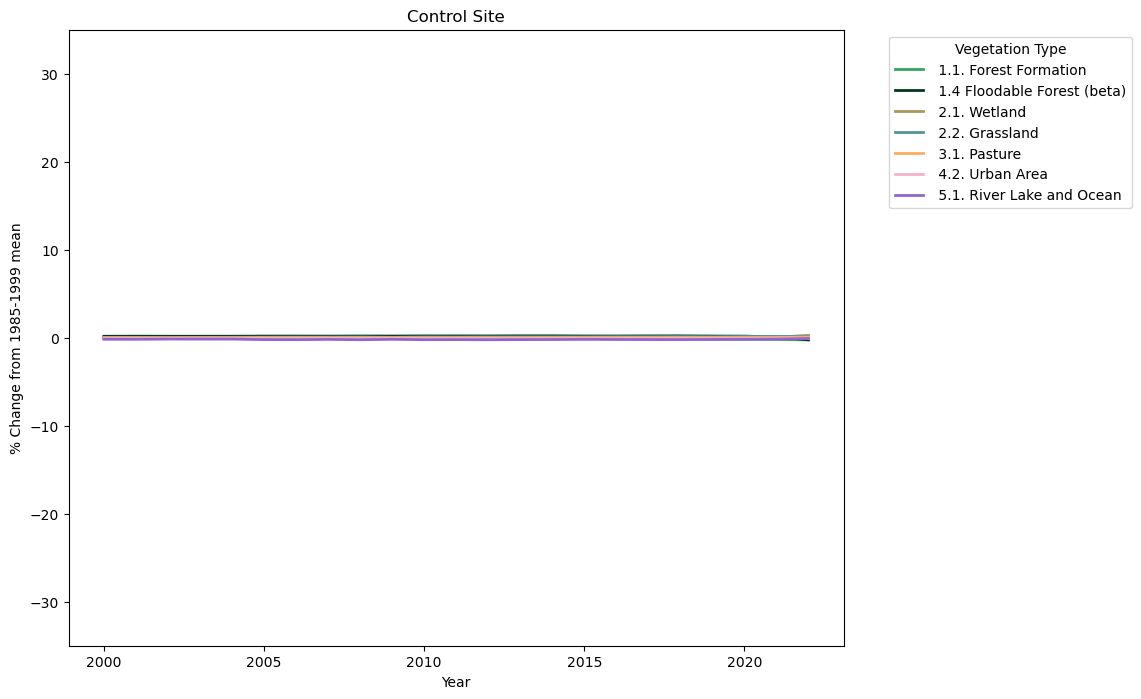

In [11]:
vegetation_area_difference('Control Site')

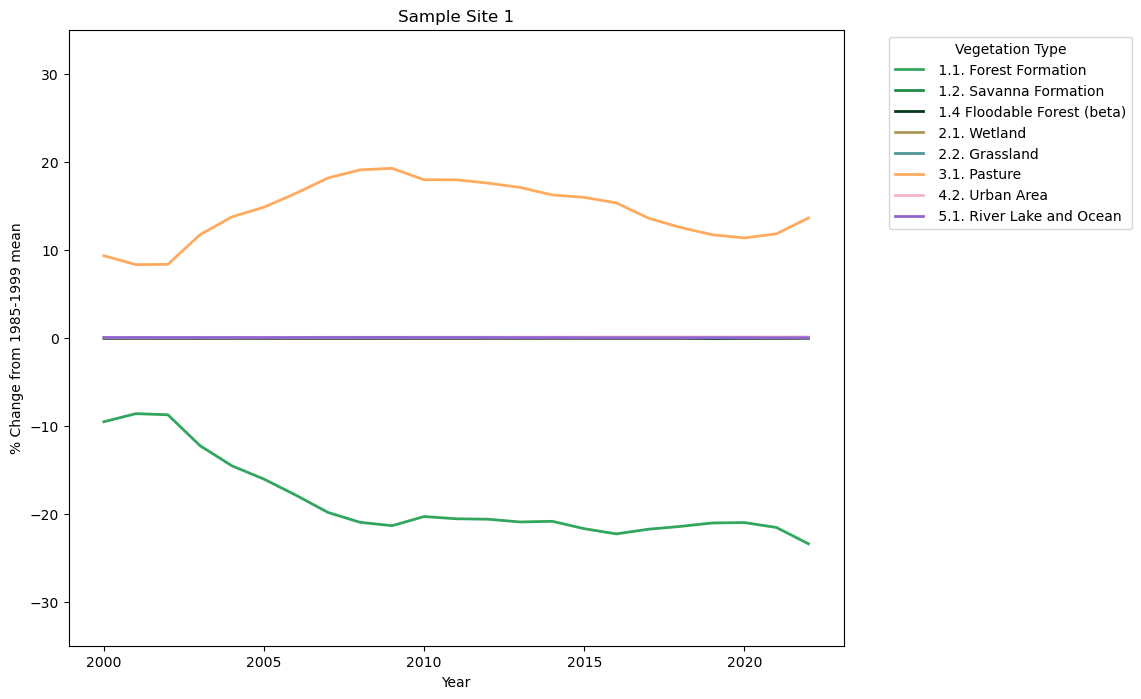

In [12]:
vegetation_area_difference('Sample Site 1')

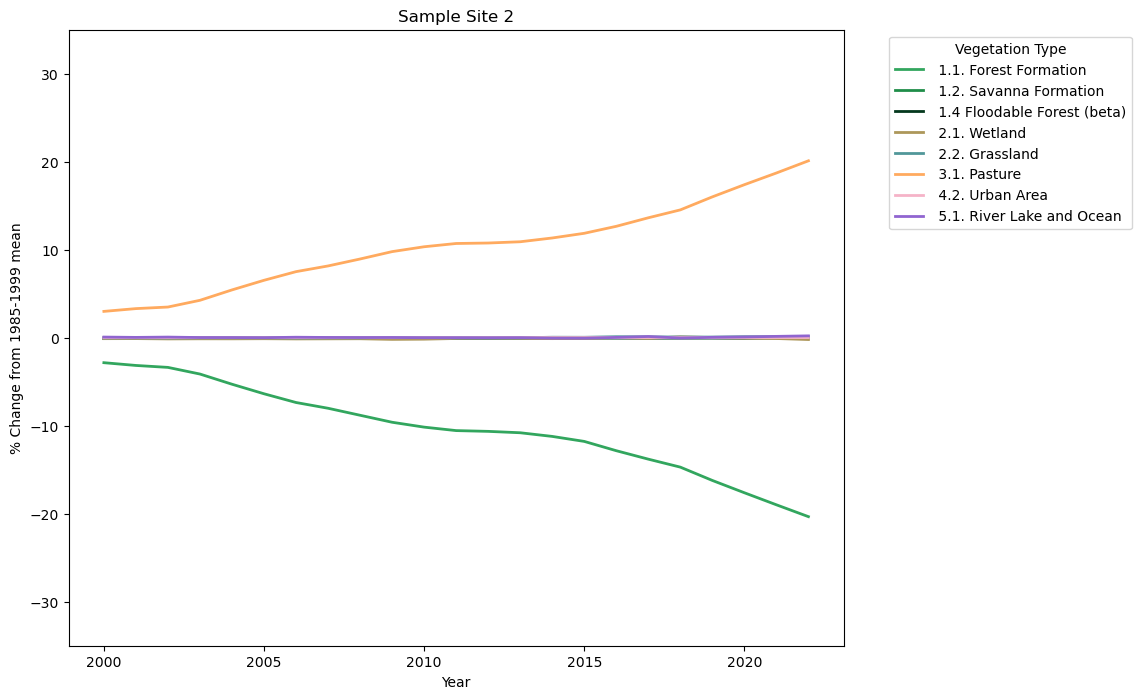

In [13]:
vegetation_area_difference('Sample Site 2')

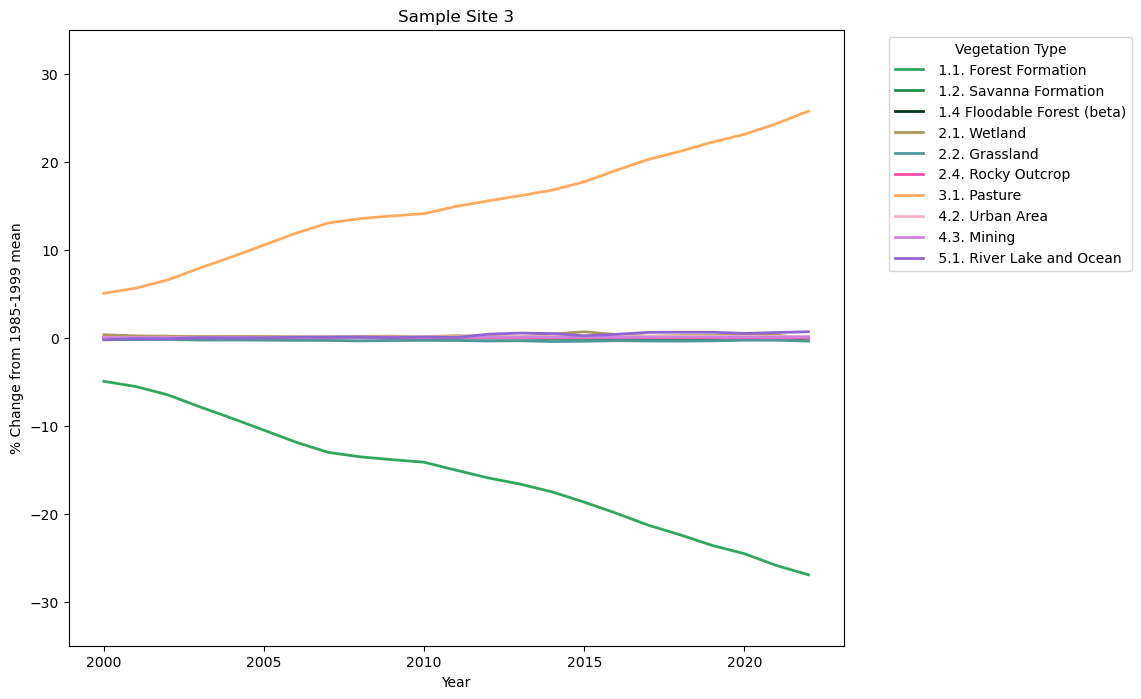

In [14]:
vegetation_area_difference('Sample Site 3')

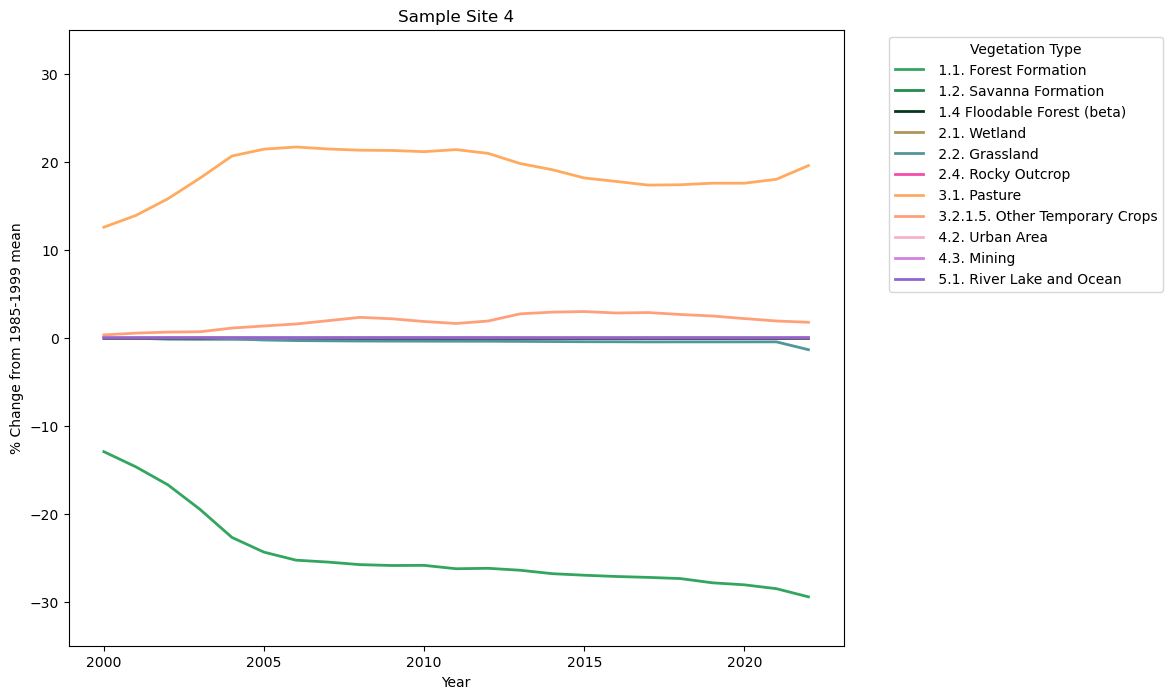

In [15]:
vegetation_area_difference('Sample Site 4')

This plots all of the above plots into a single figure and saves it into a PNG

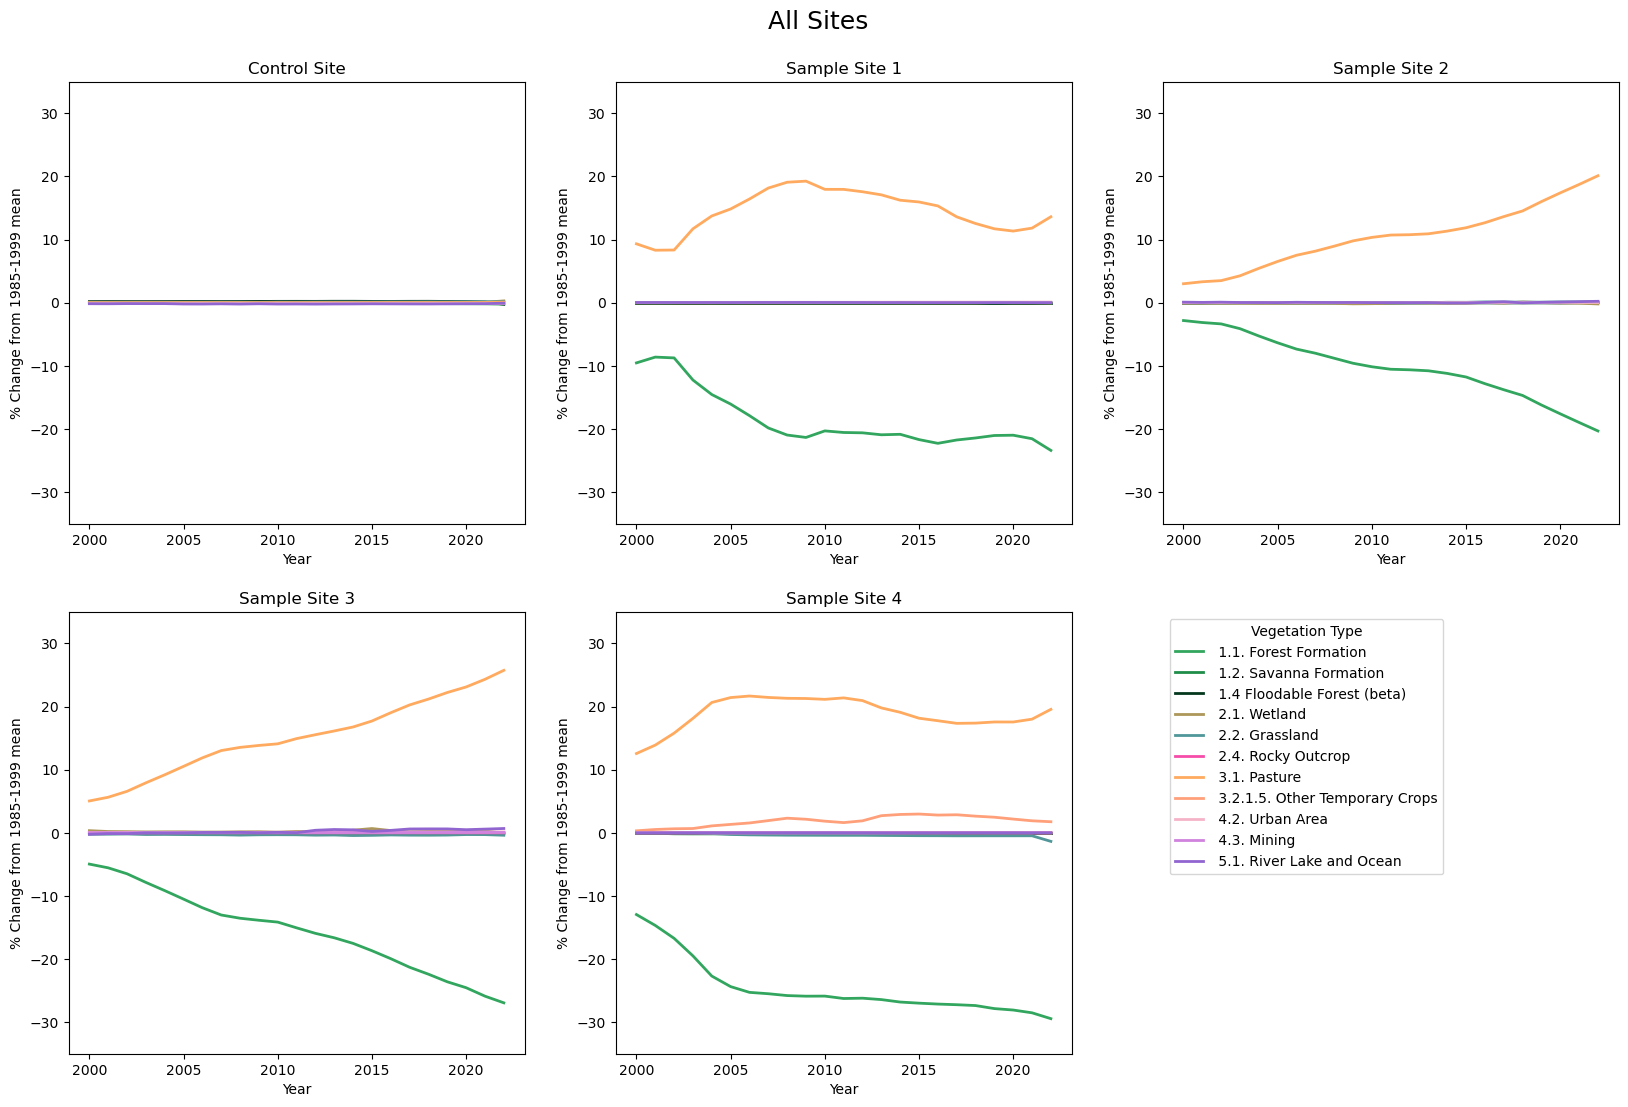

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [16]:
fig = plt.figure(figsize=(20, 12))
fig.suptitle('All Sites', fontsize=18)  
fig.subplots_adjust(top = 0.92)

ax1 = fig.add_subplot(2,3,1)
vegetation_area_difference('Control Site','Subplot',ax1)

ax2 = fig.add_subplot(2,3,2)
vegetation_area_difference('Sample Site 1','Subplot', ax2)

ax3 = fig.add_subplot(2,3,3)
vegetation_area_difference('Sample Site 2','Subplot', ax3)

ax4 = fig.add_subplot(2,3,4)
vegetation_area_difference('Sample Site 3','Subplot', ax4)

ax5 = fig.add_subplot(2,3,5)
vegetation_area_difference('Sample Site 4','Subplot', ax5)

ax5.legend(title='Vegetation Type', bbox_to_anchor=(1.2, 1), loc='upper left')

fig.savefig('vegetation_graph_all.png', bbox_inches='tight', dpi=100)